# 2-Dimensional Thermodynamic Analysis of strategy enabling anaerobic production of PHB

In this script, we calculate the MDFs of the NOG+EMP pathway (with substrate channeling between ketothiolase and acetoacetyl-CoA reductase implemented) at different combinations of AcCoA/CoA and NADH/NAD ratios. We have performed this analysis in a 100 x 100 grid, thus:

__WARNING: The calculations will take several hours (over 8h)!__

In [9]:
from equilibrator_api import Q_ #for creating quantity variables
import equilibrator_custom_functions as eq #custom functions created during analysis
import numpy as np #numerical package
import math
import matplotlib.pyplot as plt #plotting package
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import ImageGrid

Here we determine *Escherichia coli* intracellular conditions for the analysis. We also define metabolite bounds and their labels. See other scripts for more information.

In [4]:
#E. coli physiological conditions as a dictionary
E_coli_con = {
            "p_h": str(Q_("7.5")),
            "p_mg": str(Q_(10)),
            "ionic_strength": str(Q_('200 mM')),
            "temperature": str(Q_(37+273.15,"K")),
            "kcat_source": "fwd",
}

#Generating Compound Settings with the default eQuilibrator bounds
cs_default_bounds = eq.obtain_compound_settings("metabolite_reference_table", custom_bounds = False)

Before the analysis, total concentrations of the (Ac)CoA moiety and the NAD(H) moiety are determined, as well as the range of ratios which the MDF will be calculated for:

In [5]:
total_CoA_conc = Q_(0.001,'M') #'total' counting only CoA and AcCoA
conc_NADH = cs_default_bounds.bounds.GetUpperBound(cs_default_bounds.acr2cmpd_dict['NADH'])
conc_NAD = cs_default_bounds.bounds.GetUpperBound(cs_default_bounds.acr2cmpd_dict['NAD'])
total_NAD_conc = conc_NADH + conc_NAD
CoA_ratio_range = np.logspace(-1,3,100)#(-3,3,7)
NAD_ratio_range = np.logspace(-4,2,100)#(-4,2,7)

The function used for the calculation of MDF in a 2-dimensional space of metabolite ratios is __eq.MDF_double_ratio_sweep__, whose arguments are structure in tuples for each metabolite ratio. The function returns both the MDF values and full result data for every concentration point analyzed.

In [6]:
CoA_tuple = ('AcCoA','CoA',CoA_ratio_range,total_CoA_conc)
CoA_tuple_X10 = ('AcCoA','CoA',CoA_ratio_range,total_CoA_conc*10)
NAD_tuple = ('NADH','NAD',NAD_ratio_range,total_NAD_conc)
mdfs_SC, results = eq.MDF_double_ratio_sweep(CoA_tuple,NAD_tuple,"NOGEMP_SC",cs_default_bounds,E_coli_con, custom_dGs = False)
mdfs_SC_x10, results = eq.MDF_double_ratio_sweep(CoA_tuple_X10,NAD_tuple,"NOGEMP_SC",cs_default_bounds,E_coli_con, custom_dGs = False)



29001.499487638474


The results can be plotted into a contourf plot like shown below:

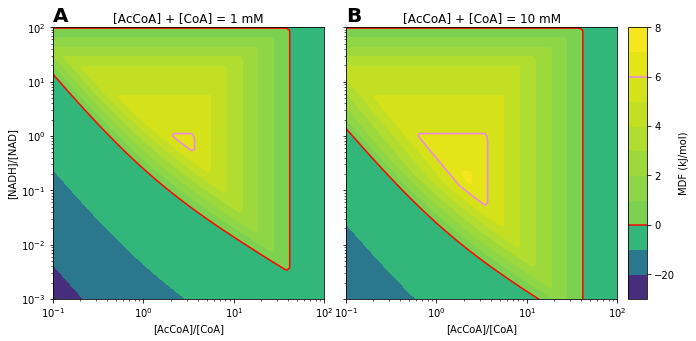

In [10]:
fig = plt.figure(figsize=(15, 5))
X, Y = np.meshgrid(CoA_ratio_range, NAD_ratio_range)


grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
)
Z = [mdfs_SC.T, mdfs_SC_x10.T]
titles = ['[AcCoA] + [CoA] = ' + val + ' mM' for val in ['1','10']]
letters = ['A','B']

for i in [0,1]:
    CS = grid[i].contourf(X,Y,Z[i],levels = np.array([-30,-20,-10,0,1,2,3,4,5,6,7,8]))
    grid[i].set_xscale("log")
    grid[i].set_yscale("log")
    grid[i].set_xlabel('[AcCoA]/[CoA]')
    grid[i].set_ylabel('[NADH]/[NAD]')
    grid[i].set_title(titles[i])
    grid[i].set_ylim(1e-3,1e2)
    grid[i].set_xlim(1e-1,1e2)
    lines = grid[i].contour(CS, levels= np.array([0,6]), colors=['r','violet'])
    grid[i].annotate(letters[i], xy=(0, 1.02), xycoords="axes fraction",fontsize = 20, fontweight = 'demibold')

cbar = plt.colorbar(CS, cax=grid[1].cax)
grid[1].cax.set_ylabel('MDF (kJ/mol)')
cbar.add_lines(lines)

plt.show()